In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


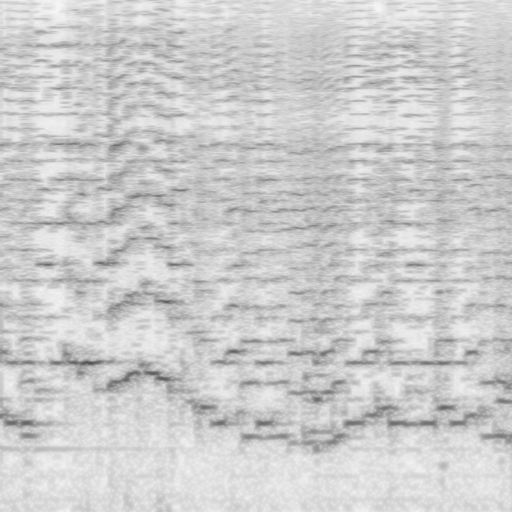

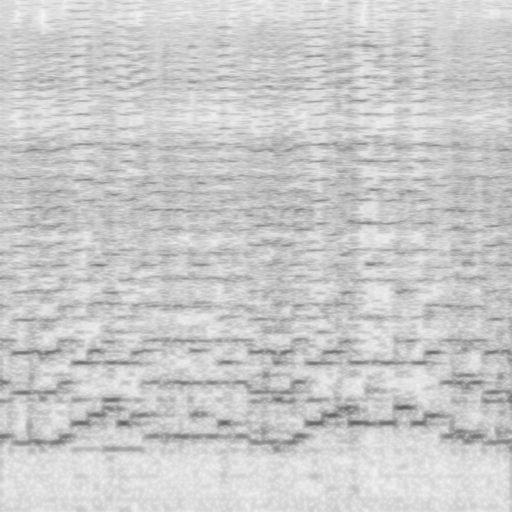

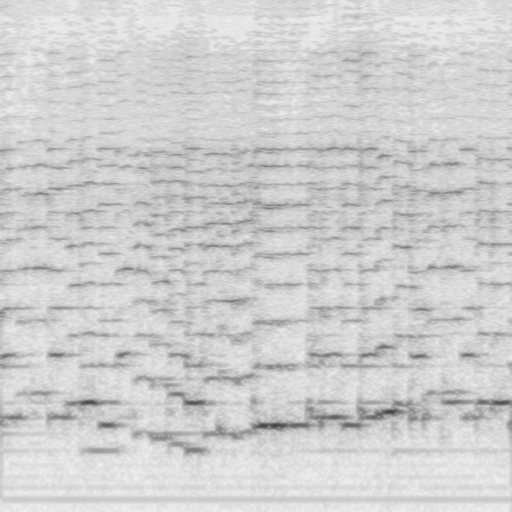

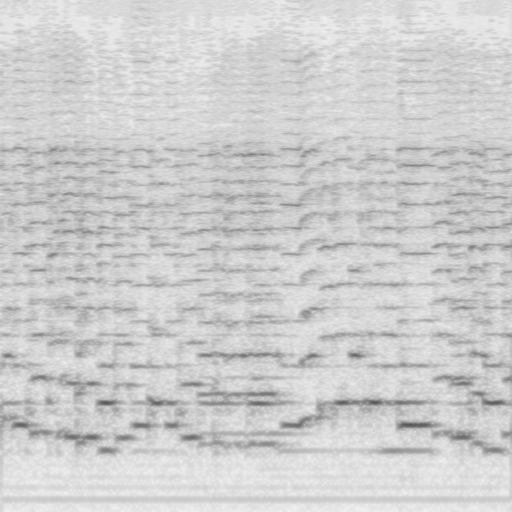

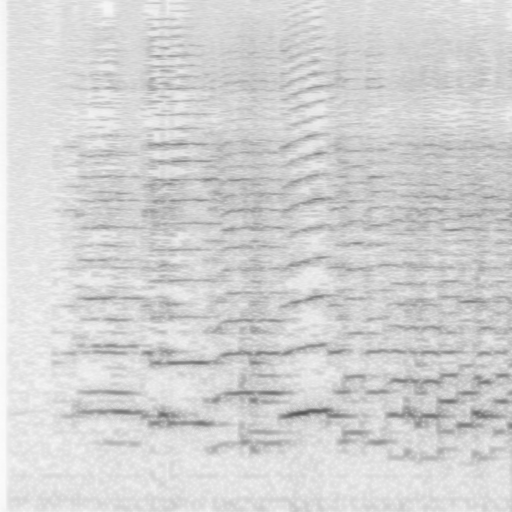

In [5]:
from PIL import Image
import os

mel_specto_instance = '/content/drive/MyDrive/mel_specto'

for file_name in os.listdir(mel_specto_instance):
  # Check if the file is an image
  if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
    # Create the full path to the image file
    specto_path = os.path.join(mel_specto_instance, file_name)

    # Load the image using PIL
    img = Image.open(specto_path)
    img.show()

## Introduction

In this example, we'll implement DreamBooth, a fine-tuning technique to teach new visual concepts to text-conditioned Diffusion models with just 3 - 5 images. DreamBooth was proposed in [DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation](https://arxiv.org/abs/2208.12242) by Ruiz et al. 

DreamBooth, in a sense, is similar to the [traditional way of fine-tuning a text-conditioned Diffusion model except](https://keras.io/examples/generative/finetune_stable_diffusion/) for a few gotchas. This example assumes that you have basic familiarity with Diffusion models and how to fine-tune them. Here are some reference examples that might help you to get familiarized quickly:

* [High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/)
* [Teach StableDiffusion new concepts via Textual Inversion](https://keras.io/examples/generative/fine_tune_via_textual_inversion/)
* [Fine-tuning Stable Diffusion](https://keras.io/examples/generative/finetune_stable_diffusion/)

First, let's install the latest versions of KerasCV and TensorFlow. 


In [6]:
!pip install git+https://github.com/costiash/stable-diffusion-tensorflow --upgrade --quiet
!pip install tensorflow tensorflow_addons ftfy --upgrade --quiet
!pip install pytorch-lightning
!pip install pydub
!pip install huggingface-hub
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -U -qq git+https://github.com/riffusion/riffusion
!pip install -qq accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes
!pip install --upgrade Pillow

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━

In [7]:
!pip install -q -U keras_cv
!pip install -q -U tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 kB 13.8 MB/s eta 0:00:00


If you're running the code, please ensure you're using a GPU with at least 24 GBs of VRAM. 

## Initial imports

In [1]:
import tensorflow as tf 

from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.stable_diffusion import StableDiffusion as StableDiffusionKeras
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
import keras

from stable_diffusion_tf.stable_diffusion import StableDiffusion as StableDiffusionPy
#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset
import pytorch_lightning as pl

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer


import bitsandbytes as bnb

def image_grid(mel_specto_instance, rows, cols):
    assert len(mel_specto_instance) == rows*cols

    w, h = mel_specto_instance[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(mel_specto_instance):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('8013'), PosixPath('//172.28.0.1'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//colab.research.google.com/tun/m/cc48301118ce

## Usage od DreamBooth

... is very versatile. By teaching Stable Diffusion about your favorite visual concepts, you can 

* Recontextualize objects in interesting ways:

  ![](https://i.imgur.com/4Da9ozw.png)

* Generate artistic renderings of the underlying visual concept: 

  ![](https://i.imgur.com/nI2N8bI.png)


And many other applications. We welcome you to check out the original DreamBooth paper in [this regard](https://arxiv.org/abs/2208.12242). 

# Upload model from Keras ckpt

In [2]:
# Comment it if you are not using a GPU having tensor cores.
tf.keras.mixed_precision.set_global_policy("mixed_float16")

#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
#pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}
#checkpoint_path = "riffusion/riffusion-model-v1"
#checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))

In [3]:
diffusion_model_pytorch_weights = keras.utils.get_file(
    origin="https://huggingface.co/riffusion/riffusion-model-v1/resolve/main/riffusion-model-v1.ckpt",
    file_hash="99a6eb51c18e16a6121180f3daa69344e571618b195533f67ae94be4eb135a57",
)

14580603928/14580603928 [==============================] - 286s 0us/step


In [4]:
resolution = 512
print(resolution)
diffusion_model=StableDiffusionPy(resolution, resolution, download_weights=False)

512


In [5]:
diffusion_model.load_weights_from_pytorch_ckpt(diffusion_model_pytorch_weights)

Loaded 196 weights for text_encoder
Loaded 686 weights for diffusion_model
Loaded 140 weights for decoder
Loaded 108 weights for encoder


  0   1: 100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


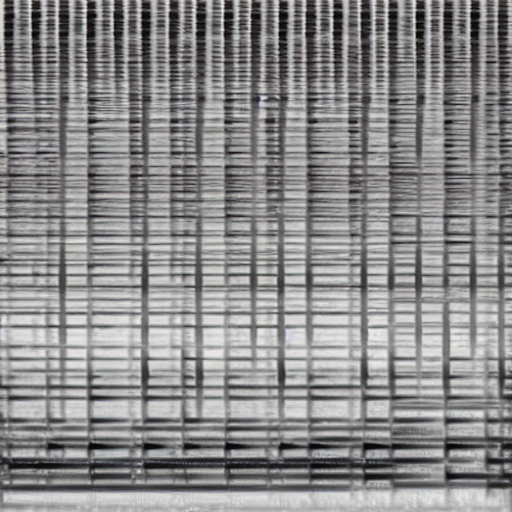

In [6]:
from PIL import Image
img = diffusion_model.generate(
    "A song",
    num_steps=100,
    unconditional_guidance_scale=7.,
    temperature=1,
    batch_size=1,
)
pil_img = Image.fromarray(img[0])

display(pil_img)

In [7]:
"""
Audio processing tools to convert between spectrogram images and waveforms.
"""
import io
import typing as T

import numpy as np

from PIL import Image
import pydub
from scipy.io import wavfile
import torch
import torchaudio


def wav_bytes_from_spectrogram_image(image: Image.Image) -> T.Tuple[io.BytesIO, float]:
    """
    Reconstruct a WAV audio clip from a spectrogram image. Also returns the duration in seconds.
    """

    max_volume = 50
    power_for_image = 0.25
    Sxx = spectrogram_from_image(image, max_volume=max_volume, power_for_image=power_for_image)

    sample_rate = 44100  # [Hz]
    clip_duration_ms = 5000  # [ms]

    bins_per_image = 512
    n_mels = 512

    # FFT parameters
    window_duration_ms = 100  # [ms]
    padded_duration_ms = 400  # [ms]
    step_size_ms = 10  # [ms]

    # Derived parameters
    num_samples = int(image.width / float(bins_per_image) * clip_duration_ms) * sample_rate
    n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
    hop_length = int(step_size_ms / 1000.0 * sample_rate)
    win_length = int(window_duration_ms / 1000.0 * sample_rate)

    samples = waveform_from_spectrogram(
        Sxx=Sxx,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        num_samples=num_samples,
        sample_rate=sample_rate,
        mel_scale=True,
        n_mels=n_mels,
        max_mel_iters=200,
        num_griffin_lim_iters=32,
    )

    wav_bytes = io.BytesIO()
    wavfile.write(wav_bytes, sample_rate, samples.astype(np.int16))
    wav_bytes.seek(0)

    duration_s = float(len(samples)) / sample_rate

    return wav_bytes, duration_s


def spectrogram_from_image(
    image: Image.Image, max_volume: float = 50, power_for_image: float = 0.25
) -> np.ndarray:
    """
    Compute a spectrogram magnitude array from a spectrogram image.
    TODO(hayk): Add image_from_spectrogram and call this out as the reverse.
    """
    # Convert to a numpy array of floats
    #data = np.array(image).astype(np.float32)

    # Flip Y take a single channel
    #data = data[::-1, :, 0]

    # Invert
    #data = 255 - data

    # Rescale to max volume
    #data = data * max_volume / 255

    # Reverse the power curve
    #data = np.power(data, 1 / power_for_image)

    #New Code
    # Convert to a numpy array of floats
    data = np.array(image).astype(np.float32)
    # Flip Y take a single channel
    if data.ndim == 2:
        data = data[::-1]
    elif data.ndim == 3:
        data = data[::-1, :, 0]
    else:
        raise ValueError(f"Unexpected number of dimensions in the data array: {data.ndim}")
    # Invert
    data = 255 - data
    # Rescale to max volume
    data = data * max_volume / 255
    # Reverse the power curve
    data = np.power(data, 1 / power_for_image)

    return data


def spectrogram_from_waveform(
    waveform: np.ndarray,
    sample_rate: int,
    n_fft: int,
    hop_length: int,
    win_length: int,
    mel_scale: bool = True,
    n_mels: int = 512,
) -> np.ndarray:
    """
    Compute a spectrogram from a waveform.
    """

    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]

    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        )

        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag


def waveform_from_spectrogram(
    Sxx: np.ndarray,
    n_fft: int,
    hop_length: int,
    win_length: int,
    num_samples: int,
    sample_rate: int,
    mel_scale: bool = True,
    n_mels: int = 512,
    max_mel_iters: int = 200,
    num_griffin_lim_iters: int = 32,
    device: str = "cuda:0",
) -> np.ndarray:
    """
    Reconstruct a waveform from a spectrogram.
    This is an approximate inverse of spectrogram_from_waveform, using the Griffin-Lim algorithm
    to approximate the phase.
    """
    Sxx_torch = torch.from_numpy(Sxx).to(device)

    # TODO(hayk): Make this a class that caches the two things

    if mel_scale:
        mel_inv_scaler = torchaudio.transforms.InverseMelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
            max_iter=max_mel_iters,
        ).to(device)

        Sxx_torch = mel_inv_scaler(Sxx_torch)

    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=1.0,
        n_iter=num_griffin_lim_iters,
    ).to(device)

    waveform = griffin_lim(Sxx_torch).cpu().numpy()

    return waveform


def mp3_bytes_from_wav_bytes(wav_bytes: io.BytesIO) -> io.BytesIO:
    mp3_bytes = io.BytesIO()
    sound = pydub.AudioSegment.from_wav(wav_bytes)
    sound.export(mp3_bytes, format="mp3")
    mp3_bytes.seek(0)
    return mp3_bytes

def image_from_spectrogram(spectrogram: np.ndarray, max_volume: float = 50, power_for_image: float = 0.25) -> Image.Image:
    """
    Compute a spectrogram image from a spectrogram magnitude array.
    """
    # Apply the power curve
    data = np.power(spectrogram, power_for_image)

    # Rescale to 0-255
    data = data * 255 / max_volume

    # Invert
    data = 255 - data

    # Convert to a PIL image
    image = Image.fromarray(data.astype(np.uint8))

    # Flip Y
    image = image.transpose(Image.FLIP_TOP_BOTTOM)

    # Convert to RGB
    image = image.convert("RGB")

    return image

In [8]:
wav = wav_bytes_from_spectrogram_image(pil_img)
with open("output_final.wav", "wb") as f:
    f.write(wav[0].getbuffer())

In [9]:
from IPython.display import Audio
display(Audio("/content/output_final.wav", rate="44100"))

## Download the instance and class images

DreamBooth uses a technique called "prior preservation" to meaningfully guide the training procedure such that the fine-tuned models can still preserve some of the prior semantics of the visual concept you're introducing. To know more about the idea of "prior preservation" refer to [this document](https://dreambooth.github.io/).

Here, we need to introduce a few key terms specific to DreamBooth:

* **Unique class**: Examples include "dog", "person", etc. In this example, we use "dog". 
* **Unique identifier**: A unique identifier that is prepended to the unique class while forming the "instance prompts". In this example, we use "sks" as this unique identifier. 
* **Instance prompt**: Denotes a prompt that best describes the "instance images". An example prompt could be - "f"a photo of {unique_id} {unique_class}". So, for our example, this becomes - "a photo  of sks dog".
* **Class prompt**: Denotes a prompt without the unique identifier. This prompt is used for generating "class images" for prior preservation. For our example, this prompt is - "a photo of dog".
* **Instance images**: Denote the images that represent the visual concept you're trying to teach aka the "instance prompt". This number is typically just 3 - 5. We typically gather these images ourselves. 
* **Class images**: Denote the images generated using the "class prompt" for using prior preservation in DreamBooth training. We leverage the pre-trained model before fine-tuning it to generate these class images. Typically, 200 - 300 class images are enough.

In code, this generation process looks quite simply:

```py
from tqdm import tqdm
import numpy as np 
import hashlib
import keras_cv
import PIL 
import os

class_images_dir = "class-images"
os.makedirs(class_images_dir, exist_ok=True)

model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)

class_prompt = "a photo of dog"
num_imgs_to_generate = 200 
for i in tqdm(range(num_imgs_to_generate)):
    images = model.text_to_image(
        class_prompt,
        batch_size=3,
    )
    idx = np.random.choice(len(images))
    selected_image = PIL.Image.fromarray(images[idx])
    
    hash_image = hashlib.sha1(selected_image.tobytes()).hexdigest()
    image_filename = os.path.join(class_images_dir, f"{hash_image}.jpg")
    selected_image.save(image_filename)
```

To keep the runtime of this example short, the authors of this example have gone ahead and generated some class images using [this notebook](https://colab.research.google.com/gist/sayakpaul/6b5de345d29cf5860f84b6d04d958692/generate_class_priors.ipynb). 

**Note** that prior preservation is an optional technique used in DreamBooth, but it almost always helps in improving the quality of the generated images. 

In [ ]:
#!tar -xzvf "/content/drive/path/input_file_name.tar.gz" -C "/content/drive/path/output_folder/" 

# instance_images_root = tf.keras.utils.get_file(
#     fname="instance_images_root",
#     origin="file://content/instance_images_root.tar.gz",
#     untar=True
# )
# class_images_root = tf.keras.utils.get_file(
#     origin="file://content/class_images_root.tar.gz",
#     untar=True
# )

## Visualize images

First, let's load the image paths. 

In [10]:
from pathlib import Path

# The path to the Spectrogram of an instance
instance_images_root = Path("/content/drive/MyDrive/mel_specto")
# The path to the Spectrogram of a Class
class_images_root = Path("/content/drive/MyDrive/class_specto")

In [11]:
from imutils import paths

instance_image_paths = list(paths.list_images(instance_images_root))
class_image_paths = list(paths.list_images(class_images_root))

instance_image_paths, class_image_paths[:5]

(['/content/drive/MyDrive/mel_specto/05_00010.png',
  '/content/drive/MyDrive/mel_specto/05_00011.png',
  '/content/drive/MyDrive/mel_specto/05_00013.png',
  '/content/drive/MyDrive/mel_specto/05_00014.png',
  '/content/drive/MyDrive/mel_specto/05_00012.png'],
 ['/content/drive/MyDrive/class_specto/05_00020.png',
  '/content/drive/MyDrive/class_specto/05_00017.png',
  '/content/drive/MyDrive/class_specto/05_00018.png',
  '/content/drive/MyDrive/class_specto/05_00016.png',
  '/content/drive/MyDrive/class_specto/05_00019.png'])

Then we load the images from the paths. 

In [12]:
from PIL import Image
import numpy as np

def load_images(image_paths):
    images = [] 
    for path in image_paths:
        image = Image.open(path)
        images.append(np.array(image))
    return images

And then we make use a utility function to plot the loaded images. 

In [13]:
import matplotlib.pyplot as plt

def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i], cmap='gray')
        plt.axis("off")

**Instance images**:

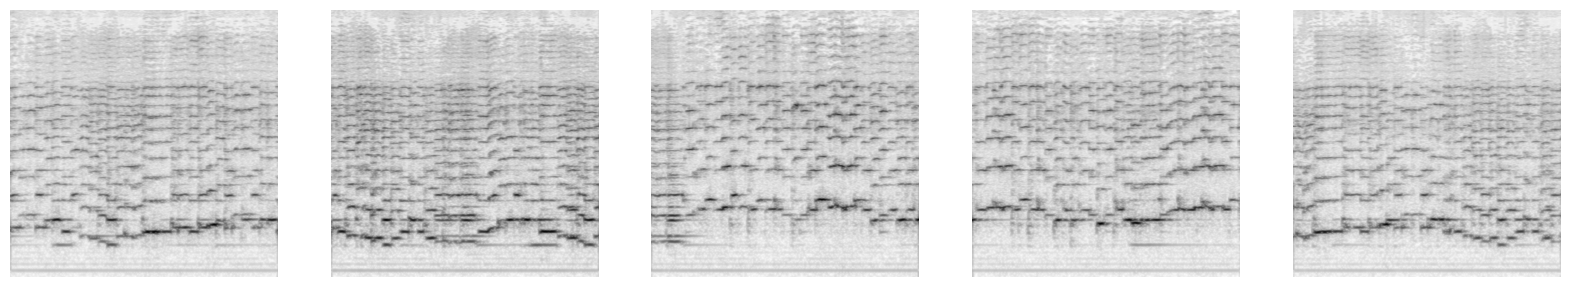

In [14]:
plot_images(load_images(instance_image_paths[:5]))

**Class images**:

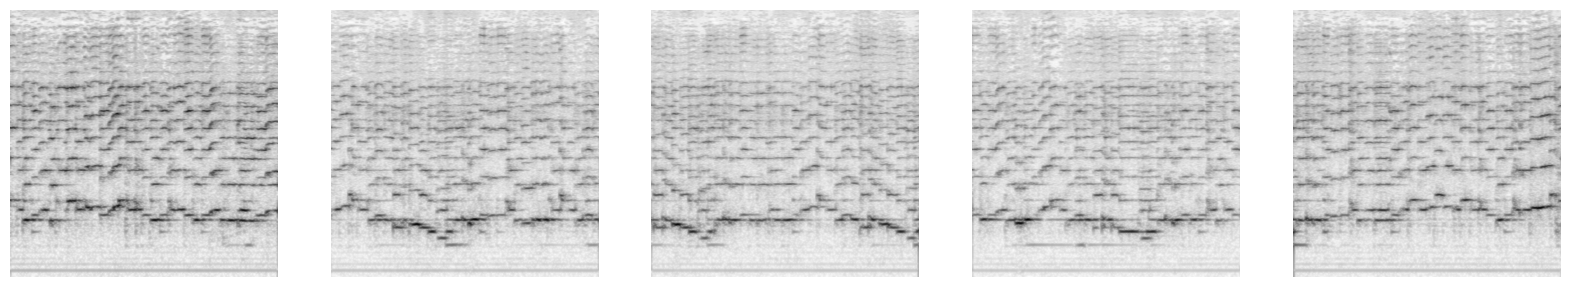

In [15]:
plot_images(load_images(class_image_paths[:5]))

## Prepare datasets

Dataset preparation includes two stages: (1): preparing the captions, (2) processing the images.

### Prepare the captions

In [51]:
# Since we're using prior preservation, we need to match the number
# of instance images we're using. We just repeat the instance image paths
# to do so. 
new_instance_image_paths = []
for index in range(len(class_image_paths)):
    instance_image = instance_image_paths[index % len(instance_image_paths)]
    new_instance_image_paths.append(instance_image)

In [52]:
# We just repeat the prompts / captions per images. 
unique_id = "Irish Folk"
class_label = "Song"

instance_prompt = f"a {unique_id} {class_label}" 
instance_prompts = [instance_prompt] * len(new_instance_image_paths)

class_prompt = f"a {class_label}"
class_prompts = [class_prompt] * len(class_image_paths)

Next, we embed the prompts to save some compute.  

In [53]:
import numpy as np
import itertools

# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
padding_token = 49407
max_prompt_length = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

# Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [padding_token] * (max_prompt_length - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(instance_prompts) + len(class_prompts), max_prompt_length))

for i, caption in enumerate(itertools.chain(instance_prompts, class_prompts)):
    tokenized_texts[i] = process_text(caption)


# We also pre-compute the text embeddings to save some memory during training. 
POS_IDS = tf.convert_to_tensor([list(range(max_prompt_length))], dtype=tf.int32)
text_encoder = TextEncoder(max_prompt_length)

gpus = tf.config.list_logical_devices("GPU")

# Ensure the computation takes place on a GPU.
with tf.device(gpus[0].name):
    embedded_text = text_encoder(
        [tf.convert_to_tensor(tokenized_texts), POS_IDS], training=False
    ).numpy()

# To ensure text_encoder doesn't occupy any GPU space.
del text_encoder

## Prepare the images

In [54]:
import keras_cv

resolution = 512
auto = tf.data.AUTOTUNE

augmenter = keras_cv.layers.Augmenter(
    layers=[
        keras_cv.layers.CenterCrop(resolution, resolution),
        #keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    return image, tokenized_text


def apply_augmentation(image_batch, embedded_tokens):
    return augmenter(image_batch), embedded_tokens


def prepare_dict(instance_only=True):
    def fn(image_batch, embedded_tokens):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_embedded_texts": embedded_tokens,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_embedded_texts": embedded_tokens,
            }
            return batch_dict
    return fn


def assemble_dataset(
    image_paths, embedded_texts, instance_only=True, batch_size=1
):  
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_paths, embedded_texts)
    )
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
    return dataset

## Assemble dataset

In [55]:
instance_dataset = assemble_dataset(
    new_instance_image_paths, 
    embedded_text[:len(new_instance_image_paths)],
)
class_dataset = assemble_dataset(
    class_image_paths, 
    embedded_text[len(new_instance_image_paths):],
    instance_only=False
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

## Check shapes

Now that the dataset has been prepared, let's quickly check what's inside it. 

In [56]:
sample_batch = next(iter(train_dataset))
print(sample_batch[0].keys(), sample_batch[1].keys())

dict_keys(['instance_images', 'instance_embedded_texts']) dict_keys(['class_images', 'class_embedded_texts'])


In [57]:
for k in sample_batch[0]:
    print(k, sample_batch[0][k].shape)

instance_images (1, 512, 512, 3)
instance_embedded_texts (1, 77, 768)


In [58]:
for k in sample_batch[1]:
    print(k, sample_batch[1][k].shape)

class_images (1, 512, 512, 3)
class_embedded_texts (1, 77, 768)


During training, we make use of these keys to gather the images and text embeddings and concat them accordingly. 

## DreamBooth training loop

Our DreamBooth training loop is very much inspired by [this script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py) provided by the Diffusers team at Hugging Face. However, there is an important difference to note. We only fine-tune the UNet (the model responsible for predicting noise) and don't fine-tune the text encoder in this example. If you're looking for an implementation that also performs the additional fine-tuning of the text encoder, refer to [this repository](https://github.com/sayakpaul/dreambooth-keras/). 

In [59]:
import tensorflow.experimental.numpy as tnp

class DreamBoothTrainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_embedded_text = instance_batch["instance_embedded_texts"]
        class_images = class_batch["class_images"]
        class_embedded_text = class_batch["class_embedded_texts"]

        images = tf.concat([instance_images, class_images], 0)
        embedded_texts = tf.concat([instance_embedded_text, class_embedded_text], 0)
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, embedded_texts], #training=True
            )
            loss = self.compute_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def compute_loss(self, target, model_pred):
        # Chunk the noise and model_pred into two parts and compute the loss
        # on each part separately.
        # Since the first half of the inputs has instance samples and the second half
        # has class samples, we do the chunking accordingly. 
        model_pred, model_pred_prior = tf.split(model_pred, num_or_size_splits=2, axis=0)
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.compiled_loss(target, model_pred)

        # Compute prior loss.
        prior_loss = self.compiled_loss(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

## Trainer initialization

In [60]:
use_mp = True # Set it to False if you're not using a GPU with tensor cores. 

image_encoder = ImageEncoder(resolution, resolution)
dreambooth_trainer = DreamBoothTrainer(
    diffusion_model=diffusion_model.diffusion_model,
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=use_mp,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://github.com/huggingface/diffusers/tree/main/examples/dreambooth
lr = 5e-6
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
dreambooth_trainer.compile(optimizer=optimizer, loss="mse")

## Train!

We first calculate the number of epochs, we need to train for.

In [61]:
import math

num_update_steps_per_epoch = train_dataset.cardinality()
max_train_steps = 1200
epochs =  math.ceil(max_train_steps / num_update_steps_per_epoch)
print(f"Training for {epochs} epochs.")

Training for 17 epochs.


And then we start training!

In [75]:
ckpt_path = "dreambooth-unet.h5" 
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
history = dreambooth_trainer.fit(train_dataset, epochs=50, callbacks=[ckpt_callback])

Epoch 1/50
74/74 [==============================] - 42s 566ms/step - loss: 0.1025
Epoch 2/50
74/74 [==============================] - 41s 558ms/step - loss: 0.0935
Epoch 3/50
74/74 [==============================] - 41s 560ms/step - loss: 0.0689
Epoch 4/50
74/74 [==============================] - 42s 570ms/step - loss: 0.0634
Epoch 5/50
74/74 [==============================] - 42s 575ms/step - loss: 0.0911
Epoch 6/50
74/74 [==============================] - 41s 556ms/step - loss: 0.0723
Epoch 7/50
74/74 [==============================] - 42s 575ms/step - loss: 0.0746
Epoch 8/50
74/74 [==============================] - 42s 574ms/step - loss: 0.0930
Epoch 9/50
74/74 [==============================] - 41s 558ms/step - loss: 0.0910
Epoch 10/50
74/74 [==============================] - 41s 557ms/step - loss: 0.0925
Epoch 11/50
74/74 [==============================] - 41s 557ms/step - loss: 0.0951
Epoch 12/50
74/74 [==============================] - 42s 566ms/step - loss: 0.0963
Epoch 13/50
7

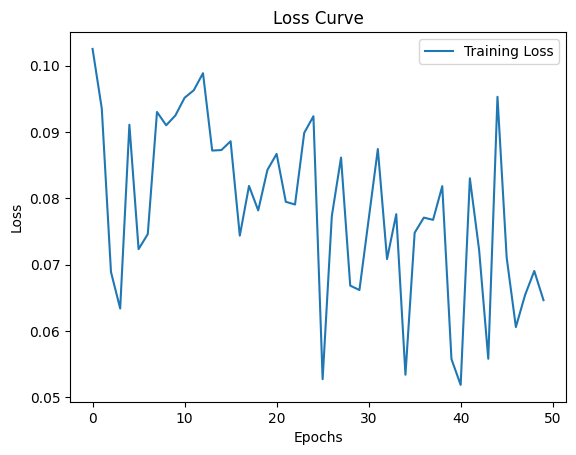

In [80]:
import matplotlib.pyplot as plt

fig , ax = plt.subplots()

ax.plot(history.history['loss'], label='Training Loss')
ax.set_title('Loss Curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')

plt.show()

# Model Hosting
To host the model, we will use [Hugging Face Hub](https://huggingface.co/). It follows an authentication with token so we need to get our write token from [this page](https://huggingface.co/settings/tokens) and we will use `notebook_login()` to pass the token. Hosting the model using utils from Hugging Face Hub enables better versioning of models with reproducibility tools, e.g. model cards, and also easy loading without storing the model locally.

In [ ]:
# # Initialize a new Stable Diffusion model.
# dreambooth_model = keras_cv.models.StableDiffusion(
#     img_width=resolution, img_height=resolution, jit_compile=True
# )

In [77]:
diffusion_model.diffusion_model.load_weights(ckpt_path)

  0   1: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


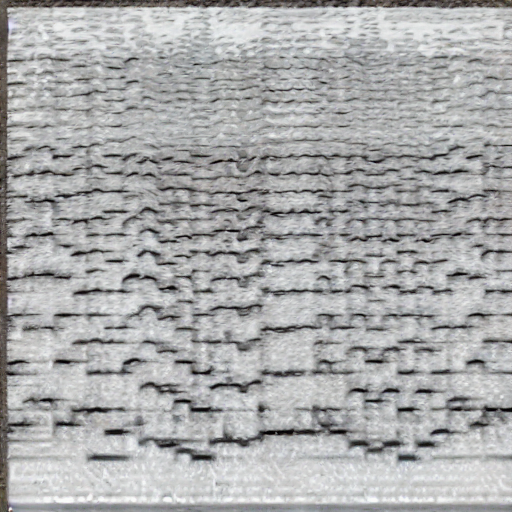

In [78]:
img = diffusion_model.generate(
    "A Irish Folk song",
    num_steps=100,
    unconditional_guidance_scale=8,
    temperature=1,
    batch_size=1,
)
pil_img = Image.fromarray(img[0])

display(pil_img)

Generated Music from the Spectrogram achieved from Diffusion

In [81]:
wav = wav_bytes_from_spectrogram_image(pil_img)
with open("output_final_2.wav", "wb") as f:
    f.write(wav[0].getbuffer())

In [82]:
from IPython.display import Audio
display(Audio("/content/output_final_2.wav", rate="44100"))

Comparison: 
Checking the audio from the dataset of Spectrograms of Irish Folk Music

In [68]:
pil_img = Image.open("/content/drive/MyDrive/mel_specto/05_00012.png")
wav = wav_bytes_from_spectrogram_image(pil_img)
with open("output_final.wav", "wb") as f:
    f.write(wav[0].getbuffer())

In [69]:
from IPython.display import Audio
display(Audio("/content/output_final.wav", rate="44100"))

In [ ]:
from IPython.display import display, FileLink

file_path = "/content/output_final_2.wav"

# Check if file exists
if os.path.exists(file_path):
    print(f"File exists at {file_path}")
    display(FileLink(file_path))  # This line creates a download link for the file
else:
    print(f"File does not exist at {file_path}")


In [ ]:
#dreambooth_model.diffusion_model.load_weights(ckpt_path)

In [73]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


To host our model, we will use `push_to_hub_keras()`. This function will save the model as `SavedModel`, create a model card that we will later edit, and push our model to Hugging Face. We will pass only the diffusion model, and provide the function with a repository ID (in this case, `merve/dreambooth_diffusion_model`). 
During push to hub, you might get warnings. Feel free to ignore them.

In [ ]:
from huggingface_hub import push_to_hub_keras

config = diffusion_model.diffusion_model.get_config()
repo_id = "hdparmar/Riffusion_Dreambooth_IrishFolkMusic_v0.1"
push_to_hub_keras(diffusion_model.diffusion_model, repo_id, config=config)

## Inference

We can load the diffusion model model from the Hub using `from_pretrained_keras()` and set it as the value of the `_diffusion_model` attribute of the `StableDiffusion` model. We will then infer with the loaded model.

In [83]:
from huggingface_hub import from_pretrained_keras

sd_dreambooth_model = keras_cv.models.StableDiffusion(
    img_width=resolution, img_height=resolution, jit_compile=True, 
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


We can now perform inference with the model.

In [84]:
sd_dreambooth_model=StableDiffusionPy(resolution, resolution, download_weights=False, jit_compile=True)

In [85]:
loaded_diffusion_model = from_pretrained_keras("hdparmar/Riffusion_Dreambooth_IrishFolkMusic_v0.1")


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/huggingface_hub/keras_mixin.py:273 in                     │
│ from_pretrained_keras                                                                            │
│                                                                                                  │
│   270 │                                                                                          │
│   271 │   </Tip>                                                                                 │
│   272 │   """                                                                                    │
│ ❱ 273 │   return KerasModelHubMixin.from_pretrained(*args, **kwargs)                             │
│   274                                                                                            │
│   275                                                                                            │
│   276 @validate_hf_hub_args                                                                      │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/huggingface_hub/utils/_validators.py:120 in _inner_fn     │
│                                                                                                  │
│   117 │   │   if check_use_auth_token:                                                           │
│   118 │   │   │   kwargs = smoothly_deprecate_use_auth_token(fn_name=fn.__name__, has_token=ha   │
│   119 │   │                                                                                      │
│ ❱ 120 │   │   return fn(*args, **kwargs)                                                         │
│   121 │                                                                                          │
│   122 │   return _inner_fn  # type: ignore                                                       │
│   123                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/huggingface_hub/utils/_deprecation.py:31 in inner_f       │
│                                                                                                  │
│    28 │   │   def inner_f(*args, **kwargs):                                                      │
│    29 │   │   │   extra_args = len(args) - len(all_args)                                         │
│    30 │   │   │   if extra_args <= 0:                                                            │
│ ❱  31 │   │   │   │   return f(*args, **kwargs)                                                  │
│    32 │   │   │   # extra_args > 0                                                               │
│    33 │   │   │   args_msg = [                                                                   │
│    34 │   │   │   │   f"{name}='{arg}'" if isinstance(arg, str) else f"{name}={arg}"             │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/huggingface_hub/hub_mixin.py:175 in from_pretrained       │
│                                                                                                  │
│   172 │   │   │   │   config = json.load(f)                                                      │
│   173 │   │   │   model_kwargs.update({"config": config})                                        │
│   174 │   │                                                                                      │
│ ❱ 175 │   │   return cls._from_pretrained(                 

In [ ]:
sd_dreambooth_model.diffusion_model = loaded_diffusion_model

In [ ]:
# Note how the unique idenitifer and the class have been used in the prompt.
prompt = f"A {unique_id} {class_label}"
num_imgs_to_gen = 3

generated_img = sd_dreambooth_model.text_to_image(
    prompt, batch_size=num_imgs_to_gen
)
plot_images(generated_img, prompt)

Feel free to experiment with different prompts (don't forget to add the unique identifer and the class label!) to see how the results change. We welcome you to check out our codebase and more experimental results [here](https://github.com/sayakpaul/dreambooth-keras#results). You can also refer to [this blog post](https://huggingface.co/blog/dreambooth) to get more experimentation ideas.

## Acknowledgements

* Thanks to the [DreamBooth example script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py) provided by Hugging Face which helped us a lot in getting the initial implementation ready quickly. 
* Getting DreamBooth to work on human faces can be challenging. We have compiled some general recoomendations [here](https://github.com/sayakpaul/dreambooth-keras#notes-on-preparing-data-for-dreambooth-training-of-faces). Thanks to [Abhishek Thakur](https://no.linkedin.com/in/abhi1thakur) for helping with these. 